# Cell painting data loading

In this notebook we load the cell painting data and test out some broad phenotype definitions.

In [1]:
# Setup and imports
import pandas as pd
import dask.dataframe as dd
import seaborn as sns

In [2]:
# Template for loading profiles
profile_uri_template = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

# Template for loading negative control normalized profiles
negcon_norm_profile_uri_template = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}_normalized_negcon.parquet"
)

In [29]:
# Load metadata
plates = pd.read_csv("datasets/metadata/plate.csv.gz")
wells = pd.read_csv("datasets/metadata/well.csv.gz")
orf = pd.read_csv("datasets/metadata/orf.csv.gz")
crispr = pd.read_csv("datasets/metadata/crispr.csv.gz", dtype={'Metadata_NCBI_Gene_ID': 'str'})
compound = pd.read_csv("datasets/metadata/compound.csv.gz")

In [4]:
plates.Metadata_PlateType.value_counts()

Metadata_PlateType
COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: count, dtype: int64

Wells (and profiles) are identified by their `Metadata_{Source, Plate, Well}` triple.

We need to attach metadata about the genetic perturbation to each well.

In [5]:
orf

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
1,JCP2022_900003,ccsbBroad304_00002,ORF005388.1_TRC304.1,pLX_304,NM_001088.3,AANAT,15,9606,aralkylamine N-acetyltransferase,100.0,621.0,trt
2,JCP2022_900004,ccsbBroad304_00003,ORF003876.1_TRC304.1,pLX_304,NM_000663.4,ABAT,18,9606,4-aminobutyrate aminotransferase,100.0,1500.0,trt
3,JCP2022_900005,ccsbBroad304_00007,ORF004679.1_TRC304.1,pLX_304,NM_000018.4,ACADVL,37,9606,acyl-CoA dehydrogenase very long chain,100.0,1965.0,trt
4,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt
...,...,...,...,...,...,...,...,...,...,...,...,...
15137,JCP2022_915128,ccsbBroad304_99985,ORFC00001.1_TRC304.1,pLX_304,BFP.1,BFP,BFP,CONTROL,Hahn Lab BFP,99.5,717.0,negcon
15138,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon
15139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,1650.0,negcon
15140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon


For ORF perturbations we keep the gene ID, Symbol, and prepend a string to treatment to identify that it's an ORF perturbation

In [6]:
orf_meta = orf[['Metadata_JCP2022', 'Metadata_Symbol', 'Metadata_NCBI_Gene_ID']]
orf_meta['Metadata_Perturbation'] = orf.Metadata_pert_type.apply(lambda x: f'ORF-{x}')
orf_meta

/tmp/ipykernel_8387/3138304948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orf_meta['Metadata_Perturbation'] = orf.Metadata_pert_type.apply(lambda x: f'ORF-{x}')


,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
0,JCP2022_900002,NAT1,9,ORF-trt
1,JCP2022_900003,AANAT,15,ORF-trt
2,JCP2022_900004,ABAT,18,ORF-trt
3,JCP2022_900005,ACADVL,37,ORF-trt
4,JCP2022_900006,ASIC1,41,ORF-trt
...,...,...,...,...
15137,JCP2022_915128,BFP,BFP,ORF-negcon
15138,JCP2022_915129,HcRed,HcRed,ORF-negcon
15139,JCP2022_915130,LUCIFERASE,LUCIFERASE,ORF-negcon
15140,JCP2022_915131,LacZ,LacZ,ORF-negcon


In [7]:
orf_meta[orf_meta.Metadata_Perturbation == 'ORF-poscon']

,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
15141,JCP2022_915132,eGFP,eGFP,ORF-poscon


In [8]:
orf_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
ORF-trt       15137
ORF-negcon        4
ORF-poscon        1
Name: count, dtype: int64

In [9]:
crispr

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol
0,JCP2022_800001,NaN,no-guide
1,JCP2022_800002,NaN,non-targeting
2,JCP2022_800003,2,A2M
3,JCP2022_800004,127550,A3GALT2
4,JCP2022_800005,53947,A4GALT
...,...,...,...
7972,JCP2022_807973,54925,ZSCAN32
7973,JCP2022_807974,201516,ZSCAN4
7974,JCP2022_807975,79149,ZSCAN5A
7975,JCP2022_807976,7746,ZSCAN9


For CRISPR perturbations we keep the gene ID and Symbol, and infer the perturbation type. 

In [10]:
crispr_meta = crispr
crispr_meta['Metadata_Perturbation'] = crispr.Metadata_Symbol.apply(lambda x : f'CRISPR-{x}' if x in {'no-guide', 'non-targeting'} else 'CRISPR-trt')
crispr_meta

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol,Metadata_Perturbation
0,JCP2022_800001,NaN,no-guide,CRISPR-no-guide
1,JCP2022_800002,NaN,non-targeting,CRISPR-non-targeting
2,JCP2022_800003,2,A2M,CRISPR-trt
3,JCP2022_800004,127550,A3GALT2,CRISPR-trt
4,JCP2022_800005,53947,A4GALT,CRISPR-trt
...,...,...,...,...
7972,JCP2022_807973,54925,ZSCAN32,CRISPR-trt
7973,JCP2022_807974,201516,ZSCAN4,CRISPR-trt
7974,JCP2022_807975,79149,ZSCAN5A,CRISPR-trt
7975,JCP2022_807976,7746,ZSCAN9,CRISPR-trt


In [11]:
crispr_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
CRISPR-trt              7975
CRISPR-no-guide            1
CRISPR-non-targeting       1
Name: count, dtype: int64

In [32]:
compound

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...
...,...,...,...
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...


For compounds, we'll keep track of whether there's a compound perturbation or untreated. We'll also put the InChIKey in the Symbol column.

In [43]:
compound_meta = compound[['Metadata_JCP2022', 'Metadata_InChIKey']]
compound_meta['Metadata_Perturbation'] = 'Compound-trt'
compound_meta['Metadata_Perturbation'][compound_meta.Metadata_InChIKey.isna()] = 'Untreated'
compound_meta.rename(columns={'Metadata_InChIKey': 'Metadata_Symbol'}, inplace=True)
compound_meta

,Metadata_JCP2022,Metadata_Symbol,Metadata_Perturbation
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,Compound-trt
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,Compound-trt
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,Compound-trt
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,Compound-trt
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,Compound-trt
...,...,...,...
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,Compound-trt
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,Compound-trt
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,Compound-trt
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,Compound-trt


Create a common table for all genetic perturbations

In [44]:
common_meta = pd.concat([orf_meta, crispr_meta, compound_meta], ignore_index=True)

In [45]:
common_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
Compound-trt            116752
ORF-trt                  15137
CRISPR-trt                7975
ORF-negcon                   4
ORF-poscon                   1
CRISPR-no-guide              1
CRISPR-non-targeting         1
Untreated                    1
Name: count, dtype: int64

## Identifying control wells

We want to figure out how many control wells we have

In [46]:
control_conditions = common_meta[common_meta.Metadata_Perturbation.isin({'ORF-negcon', 'ORF-poscon', 'CRISPR-no-guide', 'CRISPR-non-targeting', 'Untreated'})]
control_conditions

,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
15137,JCP2022_915128,BFP,BFP,ORF-negcon
15138,JCP2022_915129,HcRed,HcRed,ORF-negcon
15139,JCP2022_915130,LUCIFERASE,LUCIFERASE,ORF-negcon
15140,JCP2022_915131,LacZ,LacZ,ORF-negcon
15141,JCP2022_915132,eGFP,eGFP,ORF-poscon
15142,JCP2022_800001,no-guide,NaN,CRISPR-no-guide
15143,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting
139871,JCP2022_999999,NaN,NaN,Untreated


In [47]:
control_wells = wells.merge(control_conditions, how='right', on=['Metadata_JCP2022'])
control_wells.groupby(['Metadata_Perturbation']).count()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID
Metadata_Perturbation,,,,,,
CRISPR-no-guide,4724,4724,4724,4724,4724,0
CRISPR-non-targeting,2754,2754,2754,2754,2754,0
ORF-negcon,3892,3892,3892,3892,3892,3892
ORF-poscon,2026,2026,2026,2026,2026,2026
Untreated,37094,37094,37094,37094,0,0


In [48]:
control_wells.groupby(['Metadata_Perturbation']).Metadata_Plate.unique().map(len)

Metadata_Perturbation
CRISPR-no-guide         148
CRISPR-non-targeting    148
ORF-negcon              237
ORF-poscon              237
Untreated               702
Name: Metadata_Plate, dtype: int64

## Phenotype definition using a small subset of the data

* Select a random subset of 10 CRISPR plates
* Perform hierarchical clustering of profiles
* Display clustering dendrogram with wells labeled by perturbation type
* Perform profile correlation statistical test
* Display correlation test results on dendrogram

In [20]:
# Select 10 random crispr plates
crispr_subset = plates[plates.Metadata_PlateType == 'CRISPR'].sample(10)
crispr_subset

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
581,source_13,20221109_Run5,CP-CC9-R5-12,CRISPR
459,source_13,20220914_Run1,CP-CC9-R1-03,CRISPR
555,source_13,20221024_Run4,CP-CC9-R4-14,CRISPR
574,source_13,20221109_Run5,CP-CC9-R5-05,CRISPR
564,source_13,20221024_Run4,CP-CC9-R4-23,CRISPR
602,source_13,20221109_Run5,CP-CC9-R8-01,CRISPR
589,source_13,20221109_Run5,CP-CC9-R5-20,CRISPR
476,source_13,20220914_Run1,CP-CC9-R1-20,CRISPR
571,source_13,20221109_Run5,CP-CC9-R5-02,CRISPR
475,source_13,20220914_Run1,CP-CC9-R1-19,CRISPR


In [21]:
# Load profiles
profiles = dd.read_parquet(
    [profile_uri_template.format_map(row) for _, row in crispr_subset.iterrows()],
    storage_options={"anon": True}
)

In [52]:
# Get feature matrix
# First select the subset of profiles with actual gene perturbations
crispr_wells = wells.merge(common_meta, how='left', on=['Metadata_JCP2022'])
annotated_profiles = profiles.compute().merge(crispr_wells, how='left', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])

In [53]:
# Take a look at metadata
annotated_profiles[annotated_profiles.columns[annotated_profiles.columns.str.startswith('Metadata')]]

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
0,source_13,CP-CC9-R1-03,A01,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,NaN,Compound-trt
1,source_13,CP-CC9-R1-03,A02,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting
2,source_13,CP-CC9-R1-03,A03,JCP2022_803837,LIG1,3978,CRISPR-trt
3,source_13,CP-CC9-R1-03,A04,JCP2022_805554,PRODH,5625,CRISPR-trt
4,source_13,CP-CC9-R1-03,A05,JCP2022_802699,GJB3,2707,CRISPR-trt
...,...,...,...,...,...,...,...
3833,source_13,CP-CC9-R8-01,P20,JCP2022_802274,FASN,2194,CRISPR-trt
3834,source_13,CP-CC9-R8-01,P21,JCP2022_800701,ATP1A2,477,CRISPR-trt
3835,source_13,CP-CC9-R8-01,P22,JCP2022_802537,G3BP1,10146,CRISPR-trt
3836,source_13,CP-CC9-R8-01,P23,JCP2022_800001,no-guide,NaN,CRISPR-no-guide


In [55]:
(
    annotated_profiles
        [['Metadata_Well', 'Metadata_JCP2022', 'Metadata_Symbol', 'Metadata_Perturbation']]
        [annotated_profiles.Metadata_Perturbation != 'CRISPR-trt'].
    groupby(['Metadata_JCP2022', 'Metadata_Symbol', 'Metadata_Perturbation'], dropna=False).
    count()
)

,,,Metadata_Well
Metadata_JCP2022,Metadata_Symbol,Metadata_Perturbation,
JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,Compound-trt,40
JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,Compound-trt,40
JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,Compound-trt,80
JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,Compound-trt,40
JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,Compound-trt,40
JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,Compound-trt,40
JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,Compound-trt,39
JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,Compound-trt,40
JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,Compound-trt,40


In [60]:
# Get subset of full profile columns
numeric_profiles = annotated_profiles.select_dtypes(include='number')
feature_cols = numeric_profiles.columns[~numeric_profiles.columns.str.startswith('Metadata') & ~numeric_profiles.isna().any()]

In [61]:
# Get matrix
profile_mat = annotated_profiles[feature_cols].to_numpy()

profile_mat.shape

(3838, 4760)

Look into how these columns structured

In [63]:
colparts = pd.Series(feature_cols).str.split(pat='_', expand=True)
for _, part in colparts.items():
    print(part.value_counts())

0
Cells        1255
Cytoplasm    1240
Nuclei       1176
Image        1089
Name: count, dtype: int64
1
Texture               3120
RadialDistribution     402
Intensity              335
Granularity            320
Correlation            240
AreaShape              160
ImageQuality           107
Location                33
Neighbors               21
Threshold               12
ObjectSkeleton           4
Children                 2
Parent                   2
Number                   2
Name: count, dtype: int64
2
Correlation             290
InfoMeas2               240
SumEntropy              240
SumVariance             240
AngularSecondMoment     240
                       ... 
NumberTrunks              1
CellsIncludingEdges       1
NumberBranchEnds          1
FormFactor                1
NucleiIncludingEdges      1
Name: count, Length: 102, dtype: int64
3
AGP                     851
DNA                     845
ER                      839
Mito                    833
RNA                     827
mit

In [64]:
# Are we losing any columns?
semantic_cols = annotated_profiles.columns[(
    annotated_profiles.columns.str.startswith('Cells') |
    annotated_profiles.columns.str.startswith('Cytoplasm') |
    annotated_profiles.columns.str.startswith('Nuclei') |
    annotated_profiles.columns.str.startswith('Image')
)]

print(set(semantic_cols) - set(feature_cols))
print(set(feature_cols) - set(semantic_cols))

{'Cytoplasm_AreaShape_FormFactor', 'Cells_AreaShape_FormFactor'}
set()


### Normalize one of the plates with pycytominer

We want to see how reasonable it is to normalize things on our end, so we will select one plate to work with and run its profiles through pycytominer's normalization.

In [58]:
plate_id = crispr_subset.sample(1)
plate_id

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
602,source_13,20221109_Run5,CP-CC9-R8-01,CRISPR


In [67]:
import pycytominer

plate_df = annotated_profiles[annotated_profiles.Metadata_Plate.isin(plate_id.Metadata_Plate)]

# Normalizing against crispr-no-guide
normalized_plate_df = pycytominer.normalize(
    profiles=plate_df,
    features=list(semantic_cols),
    image_features=True, #? Is this correct ?
    method="standardize",
    samples="Metadata_Perturbation == 'CRISPR-no-guide'"
)

normalized_plate_df

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
3454,source_13,CP-CC9-R8-01,A01,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,NaN,Compound-trt,0.234477,0.219663,2.963806,...,0.247839,0.121955,0.217732,0.243681,0.226793,0.241599,0.250897,0.273261,0.263933,0.271095
3455,source_13,CP-CC9-R8-01,A02,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting,0.984631,0.790146,0.714552,...,0.988080,0.910640,0.943301,0.968497,0.944922,0.955611,0.970737,0.989765,0.973267,0.997668
3456,source_13,CP-CC9-R8-01,A03,JCP2022_800573,ARHGEF7,8874,CRISPR-trt,1.617148,1.445912,1.479517,...,2.610111,2.406681,2.735375,2.748583,2.730299,2.745416,2.755349,2.739476,2.755373,2.728422
3457,source_13,CP-CC9-R8-01,A04,JCP2022_806794,ST13,6767,CRISPR-trt,2.588647,2.387805,-1.866625,...,2.983148,2.867995,3.040176,3.065850,3.041939,3.058236,3.065477,3.053425,3.075699,3.083646
3458,source_13,CP-CC9-R8-01,A05,JCP2022_802800,GPHN,10243,CRISPR-trt,3.293899,3.119295,0.577538,...,4.084833,4.090657,4.126122,4.144706,4.124615,4.129987,4.126796,4.144199,4.142057,4.131029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,source_13,CP-CC9-R8-01,P20,JCP2022_802274,FASN,2194,CRISPR-trt,2.167788,2.069231,-1.024060,...,0.276184,0.283949,0.311661,0.296348,0.306469,0.295643,0.292412,0.284180,0.294384,0.287822
3834,source_13,CP-CC9-R8-01,P21,JCP2022_800701,ATP1A2,477,CRISPR-trt,4.260001,4.322785,-0.885664,...,2.715430,2.783106,2.832770,2.807140,2.829615,2.797406,2.796917,2.741581,2.789315,2.774950
3835,source_13,CP-CC9-R8-01,P22,JCP2022_802537,G3BP1,10146,CRISPR-trt,1.469158,1.298771,-2.083132,...,-0.170606,-0.165324,-0.206979,-0.228191,-0.208497,-0.213724,-0.226104,-0.221842,-0.219746,-0.202242
3836,source_13,CP-CC9-R8-01,P23,JCP2022_800001,no-guide,NaN,CRISPR-no-guide,-0.649969,-0.689682,-1.513736,...,-1.059343,-1.060295,-1.080301,-1.078781,-1.077983,-1.073819,-1.072770,-1.061811,-1.072350,-1.063360


In [69]:
# What happened to our previously omitted columns?
normalized_plate_df[['Metadata_Perturbation', 'Cytoplasm_AreaShape_FormFactor', 'Cells_AreaShape_FormFactor']]

,Metadata_Perturbation,Cytoplasm_AreaShape_FormFactor,Cells_AreaShape_FormFactor
3454,Compound-trt,1.050035,NaN
3455,CRISPR-non-targeting,1.370517,NaN
3456,CRISPR-trt,1.562188,NaN
3457,CRISPR-trt,1.126080,NaN
3458,CRISPR-trt,1.079898,NaN
...,...,...,...
3833,CRISPR-trt,1.767896,NaN
3834,CRISPR-trt,1.561662,NaN
3835,CRISPR-trt,1.625054,NaN
3836,CRISPR-no-guide,-0.793970,NaN


Let's see how the resultant features are distributed

In [72]:
stats = normalized_plate_df.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cells_AreaShape_Area,384.0,1.810783,1.918338,-3.935038,0.961855,1.822091,2.557663,15.043143
Cells_AreaShape_BoundingBoxArea,384.0,1.846185,1.781005,-3.113366,1.044906,1.824927,2.587169,13.596907
Cells_AreaShape_BoundingBoxMaximum_X,384.0,-2.030952,3.128309,-17.591043,-3.128437,-1.176913,-0.054782,2.979505
Cells_AreaShape_BoundingBoxMaximum_Y,384.0,-2.588158,4.170849,-23.400424,-3.534862,-1.123018,0.054620,1.641289
Cells_AreaShape_BoundingBoxMinimum_X,384.0,-2.526663,2.855196,-15.109976,-3.574912,-1.871078,-0.681658,3.077504
...,...,...,...,...,...,...,...,...
Nuclei_Texture_Variance_RNA_3_03_256,384.0,2.079828,2.136146,-2.067960,0.738488,1.793193,3.044953,18.783307
Nuclei_Texture_Variance_RNA_5_00_256,384.0,2.076746,2.138402,-2.060474,0.736055,1.785227,3.049076,18.946242
Nuclei_Texture_Variance_RNA_5_01_256,384.0,2.051051,2.113669,-2.025498,0.733780,1.742152,3.006242,18.665637
Nuclei_Texture_Variance_RNA_5_02_256,384.0,2.071739,2.136847,-2.063961,0.734613,1.772823,3.035221,18.992524


In [76]:
stats_for_plot = stats.iloc[:, 3:].stack().reset_index()
stats_for_plot.columns = ['feature', 'stat', 'value']
feature_rank = stats_for_plot[stats_for_plot.stat == '50%']
feature_rank['rank'] = feature_rank.value.rank()
stats_for_plot = stats_for_plot.merge(feature_rank, on='feature')

/tmp/ipykernel_8387/2934142461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_rank['rank'] = feature_rank.value.rank()


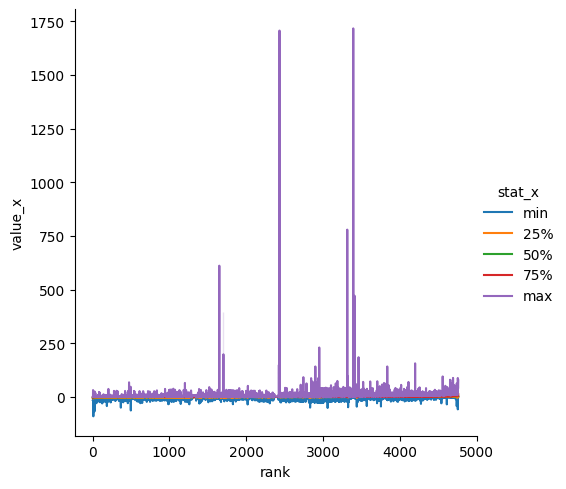

In [77]:
sns.relplot(
    stats_for_plot,
    x='rank',
    y='value_x',
    hue='stat_x',
    kind='line'
)

### 10 plate clustering

Let us normalize our 10 plates (each individually) and see (1) whether we see batch effects and (2) whether the controls cluster

In [81]:
normalized_profiles = annotated_profiles.groupby('Metadata_Plate').apply(
    pycytominer.normalize,
    # profiles is first positional argument
    features="infer",
    image_features=True, # Include Image_### features
    method="standardize",
    samples="Metadata_Perturbation == 'CRISPR-no-guide'"
).reset_index('Metadata_Plate', drop=True)
normalized_profiles

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_13,CP-CC9-R1-03,A01,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,NaN,Compound-trt,1.540494,1.471051,-1.872922,...,0.899746,0.899309,0.895590,0.889145,0.894378,0.885042,0.881281,0.889207,0.887831,0.875215
1,source_13,CP-CC9-R1-03,A02,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting,2.328922,2.357758,1.105859,...,2.841815,2.703792,2.887957,2.896619,2.893015,2.894492,2.896400,2.907768,2.908473,2.896100
2,source_13,CP-CC9-R1-03,A03,JCP2022_803837,LIG1,3978,CRISPR-trt,4.044921,3.997530,-0.457452,...,2.415871,2.410779,2.485685,2.475169,2.480887,2.459479,2.458826,2.446166,2.457569,2.417261
3,source_13,CP-CC9-R1-03,A04,JCP2022_805554,PRODH,5625,CRISPR-trt,5.503060,5.731509,0.981171,...,3.728133,3.734650,3.773812,3.753637,3.760541,3.743262,3.733557,3.738997,3.738416,3.698220
4,source_13,CP-CC9-R1-03,A05,JCP2022_802699,GJB3,2707,CRISPR-trt,5.002537,5.439474,-1.468245,...,2.090069,2.090055,2.148987,2.129561,2.135829,2.125346,2.135651,2.117672,2.122202,2.091660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,source_13,CP-CC9-R8-01,P20,JCP2022_802274,FASN,2194,CRISPR-trt,2.167788,2.069231,-1.024060,...,0.276184,0.283949,0.311661,0.296348,0.306469,0.295643,0.292412,0.284180,0.294384,0.287822
3834,source_13,CP-CC9-R8-01,P21,JCP2022_800701,ATP1A2,477,CRISPR-trt,4.260001,4.322785,-0.885664,...,2.715430,2.783106,2.832770,2.807140,2.829615,2.797406,2.796917,2.741581,2.789315,2.774950
3835,source_13,CP-CC9-R8-01,P22,JCP2022_802537,G3BP1,10146,CRISPR-trt,1.469158,1.298771,-2.083132,...,-0.170606,-0.165324,-0.206979,-0.228191,-0.208497,-0.213724,-0.226104,-0.221842,-0.219746,-0.202242
3836,source_13,CP-CC9-R8-01,P23,JCP2022_800001,no-guide,NaN,CRISPR-no-guide,-0.649969,-0.689682,-1.513736,...,-1.059343,-1.060295,-1.080301,-1.078781,-1.077983,-1.073819,-1.072770,-1.061811,-1.072350,-1.063360


In [82]:
perturbation_color_mapping = dict(zip(normalized_profiles.Metadata_Perturbation.unique(), sns.color_palette()))
plate_color_mapping = dict(zip(normalized_profiles.Metadata_Plate.unique(), sns.color_palette()))
#batch_color_mapping = dict(zip(annotated_profiles.Metadata_Batch.unique(), sns.color_palette()))

profile_annotation = normalized_profiles[['Metadata_Perturbation', 'Metadata_Plate']]
profile_annotation['Metadata_Perturbation'] = profile_annotation.Metadata_Perturbation.map(perturbation_color_mapping)
profile_annotation['Metadata_Plate'] = profile_annotation.Metadata_Plate.map(plate_color_mapping)


/tmp/ipykernel_8387/1311467039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_annotation['Metadata_Perturbation'] = profile_annotation.Metadata_Perturbation.map(perturbation_color_mapping)
/tmp/ipykernel_8387/1311467039.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_annotation['Metadata_Plate'] = profile_annotation.Metadata_Plate.map(plate_color_mapping)


In [83]:
from scipy.cluster.hierarchy import linkage, dendrogram

linkage_data = linkage(annotated_profiles[feature_cols], method='single', metric='correlation')

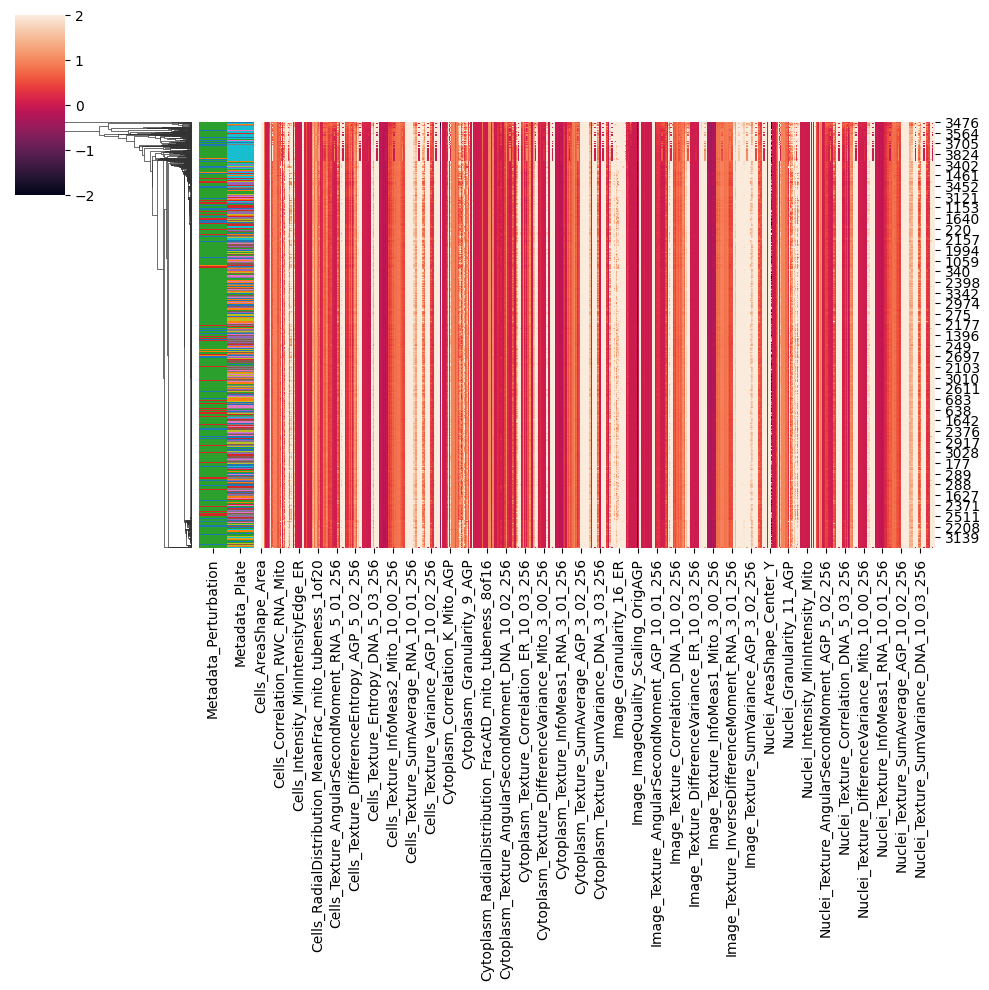

In [86]:
sns.clustermap(
    annotated_profiles[feature_cols],
    row_colors=profile_annotation[['Metadata_Perturbation', 'Metadata_Plate']],
    row_linkage=linkage_data,
    col_cluster=False,
    #standard_scale=1
    vmin=-2,
    vmax=2
)

We do, in fact, see some batch effect clustering.

/home/yuriy/.local/share/virtualenvs/morphology-prediction-GW1rJ_g8/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


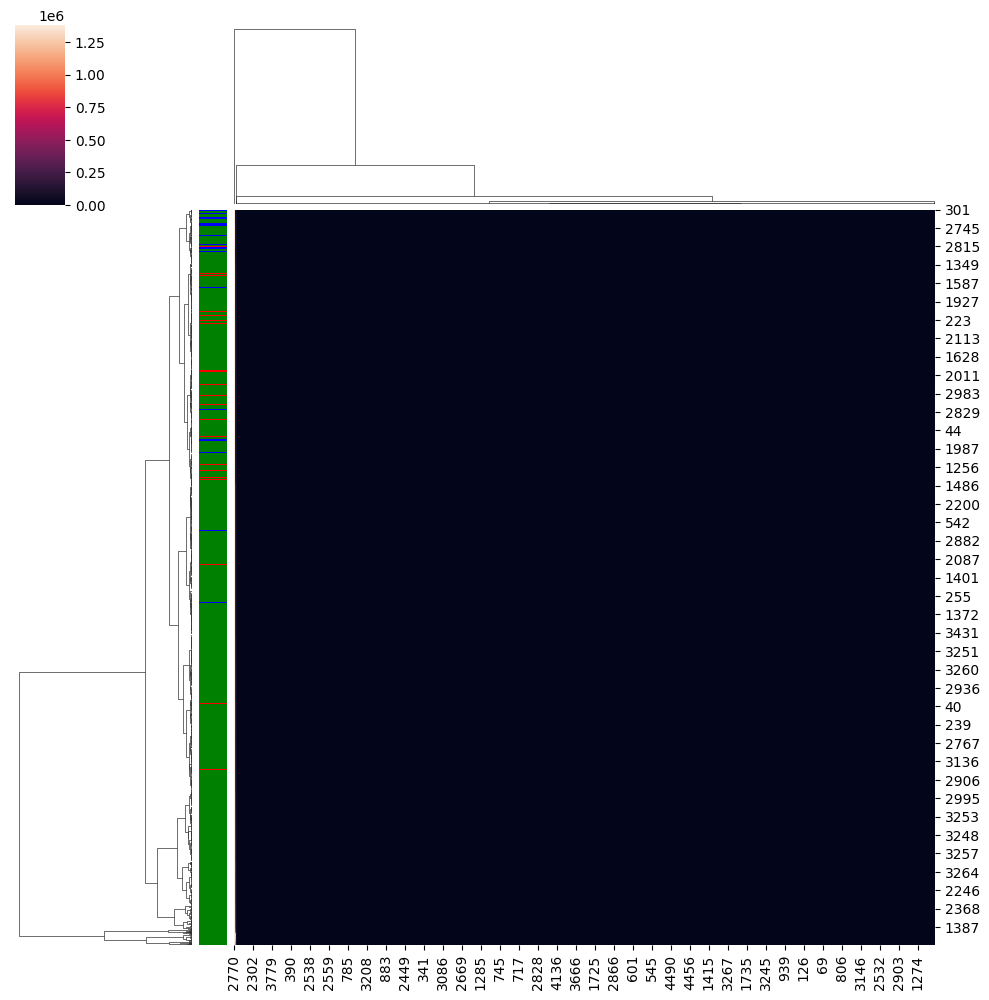

In [35]:
# Clustermap
sns.clustermap(profile_mat, row_colors = annotated_profiles.Metadata_Perturbation.map(color_mapping).to_numpy())

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [60.0, 60.0, 82.5, 82.5],
  [45.0, 45.0, 71.25, 71.25],
  [30.0, 30.0, 58.125, 58.125],
  [10.0, 10.0, 44.0625, 44.0625],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [27.03125, 27.03125, 112.5, 112.5],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [205.0, 205.0, 215.0, 215.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [210.0, 210.0, 232.5, 232.5],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [221.25, 221.25, 262.5, 262.5],
  [173.75, 173.75, 241.875, 241.875],
  [142.5, 142.5, 207.8125, 207.8125],
  [69.765625, 69.765625, 175.15625, 175.15625],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [345.0, 345.0, 355

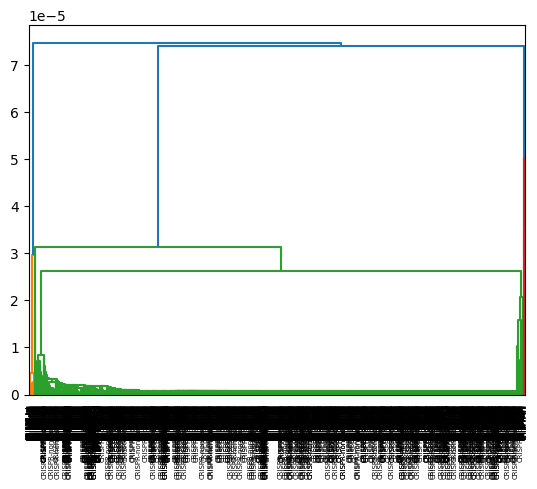

In [ ]:
# Hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram

linkage_data = linkage(profile_mat, method='single', metric='correlation')
dendrogram(linkage_data, labels=annotated_profiles.Metadata_Perturbation.to_numpy())

### Using negative-control-normalized profiles

In [41]:
# How many negcons per plate do we have
annotated_profiles.groupby('Metadata_Plate').Metadata_Perturbation.value_counts()

Metadata_Plate  Metadata_Perturbation
CP-CC9-R1-01    CRISPR-trt               321
                CRISPR-no-guide           11
                CRISPR-non-targeting      10
CP-CC9-R2-25    CRISPR-trt               323
                CRISPR-no-guide           11
                CRISPR-non-targeting      10
CP-CC9-R2-26    CRISPR-trt               323
                CRISPR-no-guide           11
                CRISPR-non-targeting      10
CP-CC9-R3-14    CRISPR-trt               322
                CRISPR-no-guide           12
                CRISPR-non-targeting      10
CP-CC9-R4-23    CRISPR-trt               323
                CRISPR-no-guide           11
                CRISPR-non-targeting      10
CP-CC9-R4-25    CRISPR-trt               323
                CRISPR-no-guide           11
                CRISPR-non-targeting      10
CP-CC9-R5-13    CRISPR-trt               323
                CRISPR-no-guide           11
                CRISPR-non-targeting      10
CP-CC9-R5-15    C

In [36]:
# Load profiles
ncn_profiles = dd.read_parquet(
    [negcon_norm_profile_uri_template.format_map(row) for _, row in crispr_subset.iterrows()],
    storage_options={"anon": True}
)

# Get feature matrix
# First select the subset of profiles with actual gene perturbations
crispr_wells = wells.merge(crispr_meta, how='inner', on=['Metadata_JCP2022'])
annotated_ncn_profiles = ncn_profiles.compute().merge(crispr_wells, how='inner', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])

# Get subset of full profile columns
ncn_numeric_profiles = annotated_profiles.select_dtypes(include='number')
ncn_feature_cols = numeric_profiles.columns[~numeric_profiles.columns.str.startswith('Metadata') & ~numeric_profiles.isna().any()]

FileNotFoundError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: cellpainting-gallery/cpg0016-jump/source_13/workspace/profiles/20220914_Run1/CP-CC9-R1-01/CP-CC9-R1-01_normalized_negcon.parquet

In [ ]:
len(ncn_feature_cols)

## Loading profiles

Let's grab all the profiles from the CRISPR and ORF plates

In [ ]:
selected_plates = plates[plates.Metadata_PlateType.isin({'ORF', 'CRISPR'})]

In [ ]:
all_profiles = dd.read_parquet(
    [profile_uri_template.format_map(row) for _, row in selected_plates.iterrows()],
    storage_options={"anon": True}
)

In [ ]:
all_profiles

,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EquivalentDiameter,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MeanRadius,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_3_3,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,Cells_AreaShape_Zernike_4_4,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_5_3,Cells_AreaShape_Zernike_5_5,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_6_4,Cells_AreaShape_Zernike_6_6,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_3,Cells_AreaShape_Zernike_7_5,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_8_0,Cells_AreaShape_Zernike_8_2,Cells_AreaShape_Zernike_8_4,Cells_AreaShape_Zernike_8_6,Cells_AreaShape_Zernike_8_8,Cells_AreaShape_Zernike_9_1,Cells_AreaShape_Zernike_9_3,Cells_AreaShape_Zernike_9_5,Cells_AreaShape_Zernike_9_7,Cells_AreaShape_Zernike_9_9,Cells_Children_Cytoplasm_Count,Cells_Correlation_Correlation_AGP_DNA,Cells_Correlation_Correlation_AGP_ER,Cells_Correlation_Correlation_AGP_Mito,Cells_Correlation_Correlation_AGP_RNA,Cells_Correlation_Correlation_DNA_ER,Cells_Correlation_Correlation_DNA_Mito,Cells_Correlation_Correlation_DNA_RNA,Cells_Correlation_Correlation_ER_Mito,Cells_Correlation_Correlation_ER_RNA,Cells_Correlation_Correlation_Mito_RNA,Cells_Correlation_K_AGP_DNA,Cells_Correlation_K_AGP_ER,Cells_Correlation_K_AGP_Mito,Cells_Correlation_K_AGP_RNA,Cells_Correlation_K_DNA_AGP,Cells_Correlation_K_DNA_ER,Cells_Correlation_K_DNA_Mito,Cells_Correlation_K_DNA_RNA,Cells_Correlation_K_ER_AGP,Cells_Correlation_K_ER_DNA,Cells_Correlation_K_ER_Mito,Cells_Correlation_K_ER_RNA,Cells_Correlation_K_Mito_AGP,Cells_Correlation_K_Mito_DNA,Cells_Correlation_K_Mito_ER,Cells_Correlation_K_Mito_RNA,Cells_Correlation_K_RNA_AGP,Cells_Correlation_K_RNA_DNA,Cells_Correlation_K_RNA_ER,Cells_Correlation_K_RNA_Mito,Cells_Correlation_Manders_AGP_DNA,Cells_Correlation_Manders_AGP_ER,Cells_Correlation_Manders_AGP_Mito,Cells_Correlation_Manders_AGP_RNA,Cells_Correlation_Manders_DNA_AGP,Cells_Correlation_Manders_DNA_ER,Cells_Correlation_Manders_DNA_Mito,Cells_Correlation_Manders_DNA_RNA,Cells_Correlation_Manders_ER_AGP,Cells_Correlation_Manders_ER_DNA,Cells_Correlation_Manders_ER_Mito,Cells_Correlation_Manders_ER_RNA,Cells_Correlation_Manders_Mito_AGP,Cells_Correlation_Manders_Mito_DNA,Cells_Correlation_Manders_Mito_ER,Cells_Correlation_Manders_Mito_RNA,Cells_Correlation_Manders_RNA_AGP,Cells_Correlation_Manders_RNA_DNA,Cells_Correlation_Manders_RNA_ER,Cells_Correlation_Manders_RNA_Mito,Cells_Correlation_Overlap_AGP_DNA,Cells_Correlation_Overlap_AGP_ER,Cells_Correlation_Overlap_AGP_Mito,Cells_Correlation_Overlap_AGP_RNA,Cells_Correlation_Overlap_DNA_ER,Cells_Correlation_Overlap_DNA_Mito,Cells_Correlation_Overlap_DNA_RNA,Cells_Correlation_Overlap_ER_Mito,Cells_Correlation_Overlap_ER_RNA,Cells_Correlation_Overlap_Mito_RNA,Cells_Correlation_RWC_AGP_DNA,Cells_Correlation_RWC_AGP_ER,Cells_Correlation_RWC_AGP_Mito,Cells_Correlation_RWC_AGP_RNA,Cells_Correlation_RWC_DNA_AGP,Cells_Correlation_RWC_DNA_ER,Cells_Correlation_RWC_DNA_Mito,Cells_Correlation_RWC_DNA_RNA,Cells_Correlation_RWC_ER_AGP,Cells_Correlation_RWC_ER_DNA,Cells_Correlation_RWC_ER_Mito,Cells_Correlation_RWC_ER_RNA,Cells_Correlation_RWC_Mito_AGP,Cells_Correlation_R

# Scratch zone

In [ ]:
wells

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,UL000081,A02,JCP2022_033924
1,source_1,UL000081,A03,JCP2022_085227
2,source_1,UL000081,A04,JCP2022_033924
3,source_1,UL000081,A05,JCP2022_047857
4,source_1,UL000081,A06,JCP2022_072229
...,...,...,...,...
1096069,source_9,GR00004421,Z44,JCP2022_999999
1096070,source_9,GR00004421,Z45,JCP2022_999999
1096071,source_9,GR00004421,Z46,JCP2022_999999
1096072,source_9,GR00004421,Z47,JCP2022_033924


In [ ]:
orf.Metadata_pert_type.value_counts()

trt       15137
negcon        4
poscon        1
Name: Metadata_pert_type, dtype: int64

In [ ]:
crispr.Metadata_Symbol.isna().any()

False

In [ ]:
big_df = plates.merge(wells, how='left', on=['Metadata_Source', 'Metadata_Plate'])

big_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022
0,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY,A02,JCP2022_033924
1,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY,A03,JCP2022_085227
2,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY,A04,JCP2022_033924
3,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY,A05,JCP2022_033924
4,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY,A06,JCP2022_033924
...,...,...,...,...,...,...
1096069,source_9,20211103-Run16,GR00004421,COMPOUND,Z44,JCP2022_999999
1096070,source_9,20211103-Run16,GR00004421,COMPOUND,Z45,JCP2022_999999
1096071,source_9,20211103-Run16,GR00004421,COMPOUND,Z46,JCP2022_999999
1096072,source_9,20211103-Run16,GR00004421,COMPOUND,Z47,JCP2022_033924


In [ ]:
# Which plate types contain ORF samples?
big_df[big_df.Metadata_JCP2022.isin(orf.Metadata_JCP2022)].Metadata_PlateType.value_counts()

ORF    86699
Name: Metadata_PlateType, dtype: int64

In [ ]:
# Which plate types contain CRISPR samples?
big_df[big_df.Metadata_JCP2022.isin(crispr.Metadata_JCP2022)].Metadata_PlateType.value_counts()

CRISPR    51192
Name: Metadata_PlateType, dtype: int64

In [ ]:
# Let's grab all the CRISPR + ORF samples and get their plate metadata
genetic_samples = big_df.merge(
    pd.concat([orf, crispr], ignore_index=True),
    how='right',
    on=['Metadata_JCP2022']
)
genetic_samples

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
0,source_4,2021_06_21_Batch7,BR00125170,ORF,E18,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
1,source_4,2021_06_21_Batch7,BR00125171,ORF,E18,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
2,source_4,2021_06_21_Batch7,BR00125172,ORF,E18,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
3,source_4,2021_06_21_Batch7,BR00125173,ORF,E18,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
4,source_4,2021_06_21_Batch7,BR00125174,ORF,E18,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137896,source_13,20220914_Run1,CP-CC9-R1-25,CRISPR,H09,JCP2022_807977,NaN,NaN,NaN,NaN,ZSWIM2,151112.0,NaN,NaN,NaN,NaN,NaN
137897,source_13,20221009_Run2,CP-CC9-R2-25,CRISPR,H09,JCP2022_807977,NaN,NaN,NaN,NaN,ZSWIM2,151112.0,NaN,NaN,NaN,NaN,NaN
137898,source_13,20221017_Run3,CP-CC9-R3-25,CRISPR,H09,JCP2022_807977,NaN,NaN,NaN,NaN,ZSWIM2,151112.0,NaN,NaN,NaN,NaN,NaN
137899,source_13,20221024_Run4,CP-CC9-R4-25,CRISPR,H09,JCP2022_807977,NaN,NaN,NaN,NaN,ZSWIM2,151112.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
genetic_samples.Metadata_pert_type.value_counts()

trt       80791
negcon     3892
poscon     2026
Name: Metadata_pert_type, dtype: int64

In [ ]:
genetic_samples[genetic_samples.Metadata_NCBI_Gene_ID.isna()]

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
66601,source_4,2021_07_26_Batch9,BR00126046,ORF,O13,JCP2022_912824,ccsbBroad304_13757,ORF000140.1_TRC304.1,pLX_304,NaN,NaN,NaN,NaN,NaN,NaN,129.0,trt
66602,source_4,2021_07_26_Batch9,BR00126047,ORF,O13,JCP2022_912824,ccsbBroad304_13757,ORF000140.1_TRC304.1,pLX_304,NaN,NaN,NaN,NaN,NaN,NaN,129.0,trt
66603,source_4,2021_07_26_Batch9,BR00126048,ORF,O13,JCP2022_912824,ccsbBroad304_13757,ORF000140.1_TRC304.1,pLX_304,NaN,NaN,NaN,NaN,NaN,NaN,129.0,trt
66604,source_4,2021_07_26_Batch9,BR00126049,ORF,O13,JCP2022_912824,ccsbBroad304_13757,ORF000140.1_TRC304.1,pLX_304,NaN,NaN,NaN,NaN,NaN,NaN,129.0,trt
66605,source_4,2021_07_26_Batch9,BR00126050,ORF,O13,JCP2022_912824,ccsbBroad304_13757,ORF000140.1_TRC304.1,pLX_304,NaN,NaN,NaN,NaN,NaN,NaN,129.0,trt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94182,source_13,20221120_Run6,CP-CC9-R8-02,CRISPR,I23,JCP2022_800002,NaN,NaN,NaN,NaN,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN
94183,source_13,20221120_Run6,CP-CC9-R8-02,CRISPR,J02,JCP2022_800002,NaN,NaN,NaN,NaN,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN
94184,source_13,20221120_Run6,CP-CC9-R8-02,CRISPR,L23,JCP2022_800002,NaN,NaN,NaN,NaN,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN
94185,source_13,20221120_Run6,CP-CC9-R8-02,CRISPR,M02,JCP2022_800002,NaN,NaN,NaN,NaN,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN


Pick a random CRISPR plate to explore

In [ ]:
# plate = plates[plates.Metadata_PlateType == 'CRISPR'].sample(1)
plate = plates[plates.Metadata_Plate == 'CP-CC9-R5-23']
plate

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
592,source_13,20221109_Run5,CP-CC9-R5-23,CRISPR


Looking at the detailed metadata:

In [ ]:
meta_s3_path = metadata_uri_template.format_map(plate.iloc[0])
detailed_metadata = pd.read_parquet(meta_s3_path, storage_options={"anon": True})
detailed_metadata

FileNotFoundError: cellpainting-gallery/cpg0016-jump/source_13/workspace/metadata/20221109_Run5/CP-CC9-R5-23/CP-CC9-R5-23.parquet

In [ ]:
meta_s3_path

's3://cellpainting-gallery/cpg0016-jump/source_13/workspace/metadata/20221109_Run5/CP-CC9-R5-23/CP-CC9-R5-23.parquet'

Looking at the profiles:

In [ ]:
s3_path = profile_uri_template.format_map(plate.iloc[0])

NameError: name 'plate' is not defined

In [ ]:
profiles = pd.read_parquet(s3_path, storage_options={"anon": True})

In [ ]:
profiles

,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_13,CP-CC9-R5-23,A01,2564.646154,4802.280342,668.487179,570.274481,600.166056,503.239316,633.838598,...,6.547658,6.232722,5.985055,6.135418,5.993420,6.132523,6.216933,6.433744,6.229385,6.439193
1,source_13,CP-CC9-R5-23,A02,3170.828715,6107.156891,675.727960,567.964016,599.186038,492.998920,636.943843,...,11.178547,10.757525,10.122509,10.355115,10.143746,10.373022,10.503368,10.882839,10.529324,10.906502
2,source_13,CP-CC9-R5-23,A03,3565.356221,6956.491885,644.444028,555.205160,561.962963,476.180191,602.788444,...,14.429889,13.996270,13.114643,13.419398,13.137789,13.417798,13.595718,14.127519,13.635929,14.128808
3,source_13,CP-CC9-R5-23,A04,3247.135221,6205.939823,653.034690,586.986549,575.189735,511.045664,613.639668,...,12.835166,12.277337,11.707850,11.955516,11.699445,11.993111,12.148838,12.584092,12.146463,12.628819
4,source_13,CP-CC9-R5-23,A05,3682.275010,7109.566077,666.755043,576.156031,584.368876,495.899135,625.165154,...,11.330945,10.972891,10.336653,10.577284,10.347326,10.564972,10.708535,11.096187,10.720598,11.060719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,source_13,CP-CC9-R5-23,P20,3809.685410,7492.009695,655.526418,566.932622,572.456617,484.753272,613.558712,...,8.619560,8.412276,7.839974,8.017215,7.832912,8.000732,8.119536,8.398918,8.124440,8.396646
380,source_13,CP-CC9-R5-23,P21,3623.604569,7007.339631,655.444200,555.888840,574.447715,475.467047,614.415720,...,9.617179,9.184005,8.671703,8.891198,8.671270,8.879872,9.028685,9.386534,9.026217,9.361639
381,source_13,CP-CC9-R5-23,P22,3664.166403,7129.243478,677.927273,556.443083,595.813834,475.109486,636.400757,...,7.223888,6.944500,6.568336,6.733048,6.574163,6.716938,6.820257,7.076138,6.835988,7.050345
382,source_13,CP-CC9-R5-23,P23,2477.854499,4542.050197,687.463567,571.596114,620.873467,506.443673,653.671140,...,6.637722,6.283346,6.072803,6.236900,6.078185,6.233929,6.320482,6.536631,6.331400,6.537714


In [ ]:
# We don't want to deal with missing data yet
profiles.columns[profiles.isna().any()]

Index(['Cells_AreaShape_FormFactor', 'Cytoplasm_AreaShape_FormFactor'], dtype='object')

In [ ]:
# Get subset of full profile columns
feature_cols = profiles.columns[~profiles.columns.str.startswith('Metadata') & ~profiles.isna().any()]

PCA plot of well profiles in the plate:

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)

profile_mat = profiles[feature_cols].to_numpy()

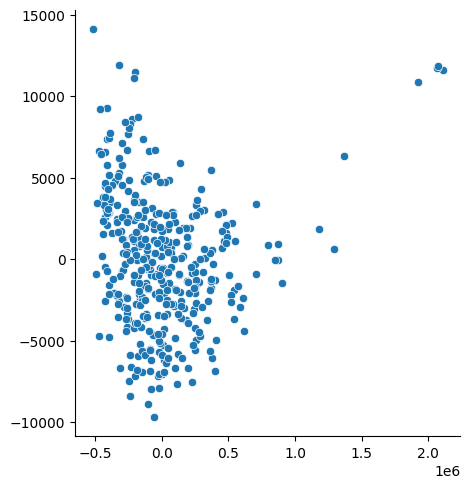

In [ ]:
decomp = pca.fit_transform(profile_mat)

sns.relplot(x=decomp[:,0], y=decomp[:,1])

In [ ]:
# Check our well genes
plate_wells = wells[wells.Metadata_Plate == 'CP-CC9-R5-23'].merge(crispr, how='left', on='Metadata_JCP2022')
plate_wells.Metadata_Symbol.value_counts(sort=True, dropna=False)

NaN              40
no-guide         11
non-targeting    10
PLK1              4
SCAND1            1
                 ..
TAF5L             1
IRX1              1
NFATC2            1
BRD8              1
HOXB4             1
Name: Metadata_Symbol, Length: 323, dtype: int64

In [ ]:
plate_wells['tag'] = 'knockdown'
plate_wells.tag[plate_wells.Metadata_Symbol.isna()] = 'none'
selection = plate_wells.Metadata_Symbol.isin({'no-guide', 'non-targeting'})
plate_wells.tag[selection] = plate_wells.Metadata_Symbol[selection]

plate_wells

/tmp/ipykernel_223/3661390046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plate_wells.tag[plate_wells.Metadata_Symbol.isna()] = 'none'
/tmp/ipykernel_223/3661390046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plate_wells.tag[selection] = plate_wells.Metadata_Symbol[selection]


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol,tag
0,source_13,CP-CC9-R5-23,A01,JCP2022_085227,NaN,NaN,none
1,source_13,CP-CC9-R5-23,A02,JCP2022_800002,NaN,non-targeting,non-targeting
2,source_13,CP-CC9-R5-23,A03,JCP2022_803144,8091.0,HMGA2,knockdown
3,source_13,CP-CC9-R5-23,A04,JCP2022_803160,6927.0,HNF1A,knockdown
4,source_13,CP-CC9-R5-23,A05,JCP2022_800266,23394.0,ADNP,knockdown
...,...,...,...,...,...,...,...
379,source_13,CP-CC9-R5-23,P20,JCP2022_802185,2101.0,ESRRA,knockdown
380,source_13,CP-CC9-R5-23,P21,JCP2022_803163,3174.0,HNF4G,knockdown
381,source_13,CP-CC9-R5-23,P22,JCP2022_803185,3214.0,HOXB4,knockdown
382,source_13,CP-CC9-R5-23,P23,JCP2022_800001,NaN,no-guide,no-guide


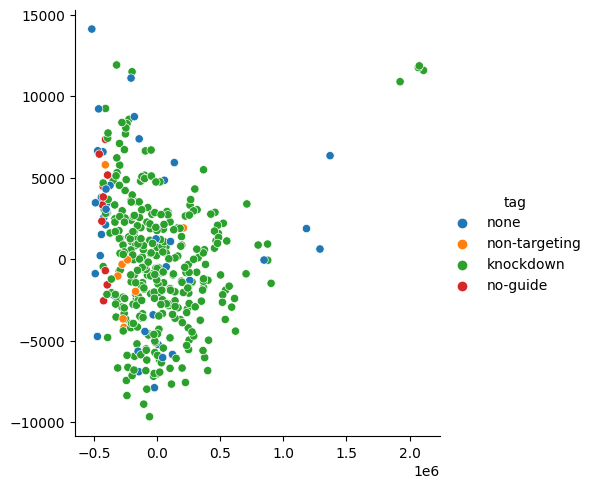

In [ ]:
tagged_profiles = profiles.merge(
    plate_wells[['Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'tag']],
    how='left',
    on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well']
)

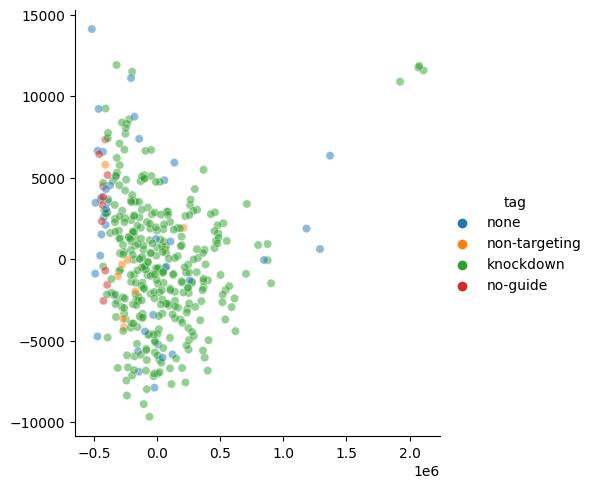

In [ ]:
sns.relplot(x=decomp[:,0], y=decomp[:,1], hue=tagged_profiles.tag, alpha=.5)